In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt



In [2]:

# study to load
study_name_list = ['PID_new_dist', 'MEKF_new_dist', 'MHE_new_dist_2']

results = []
for study_name in study_name_list:
    # load the study
    with open(f'data/logs/{study_name}.json', 'r') as f:
        dict = json.load(f)

    # load the results
    filename = f'data/signals/{dict["filename"]}'
    results.append(pd.read_csv(filename))






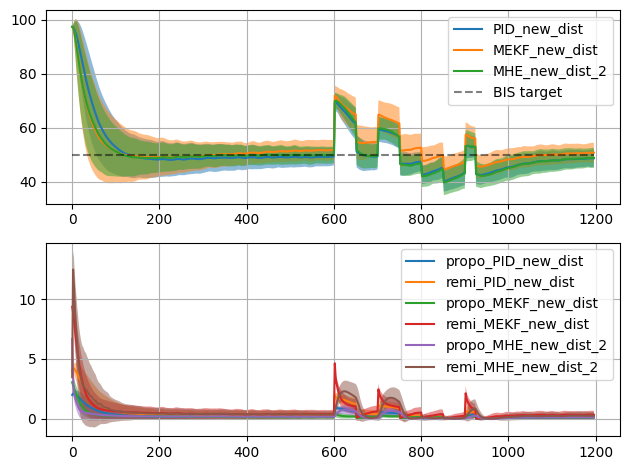

In [3]:
# plot the results
plt.subplot(2, 1, 1)
for i, result in enumerate(results):
    mean_bis = result.groupby('Time')['BIS'].mean()
 
    std_bis = result.groupby('Time')['BIS'].std()

    plt.plot(mean_bis.index, mean_bis, label=study_name_list[i])
    plt.fill_between(mean_bis.index, mean_bis - std_bis, mean_bis + std_bis, alpha=0.5)

plt.hlines(50, 0, max(mean_bis.index), 'black', '--', label='BIS target', alpha=0.5)
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
for i, result in enumerate(results):
    mean_propo = result.groupby('Time')['u_propo'].mean()
    std_propo = result.groupby('Time')['u_propo'].std()
    mean_remi = result.groupby('Time')['u_remi'].mean()
    std_remi = result.groupby('Time')['u_remi'].std()

    plt.plot(mean_propo.index, mean_propo, label=f'propo_{study_name_list[i]}')
    plt.fill_between(mean_propo.index, mean_propo - std_propo, mean_propo + std_propo, alpha=0.5)
    plt.plot(mean_remi.index, mean_remi, label=f'remi_{study_name_list[i]}')
    plt.fill_between(mean_remi.index, mean_remi - std_remi, mean_remi + std_remi, alpha=0.5)


plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(f"outputs/{''.join(study_name_list)}.pdf")

plt.show()